# Data Analytics Course – Test #2

- Date: April 30, 2021

- Submitted by [__Jieun K.__]

## Introduction

- 최근 온라인 거래를 이용하는 고객들이 많이 늘어나고 있어 고객들의 log 데이터가 많이 늘어나고 있다. 온라인 거래 고객 log 데이터를 이용하여 고객들의 미래 소비를 예측 분석 프로젝트를 진행하려 한다.

- 고객들의 월별 총 구매 금액을 확인했을 때 연말에 소비가 많이 이루어지고 있는 것으로 확인이 되었다. 12월을 대상으로 고객들에게 프로모션을 통해 성공적인 마케팅을 하기 위해 모델을 만들려고 한다.

- 온라인 거래 log 데이터는 2009년 12월부터 2011년 11월까지의 온라인 상점의 거래 데이터가 주어진다. 2011년 11월까지 데이터를 이용하여 2011년 12월의 고객 구매액 300초과 여부를 예측해야 한다.

- 고객들의 구입이 이루어질 때 1개의 데이터가 생성이 되며 데이터에는 고객에 대한 정보(고객 id / 고객 거주 국가), 상품 정보(상품 id / 상품 설명 / 상품 가격)와 거래 정보(주문 일자 / 상품 수량)로 2009년 12월 부터 2011년 11월 데이터까지 학습 데이터셋으로 주어진다.

- 데이터 컬럼: 설명

    - order_id: 주문 번호. 같은 주문번호는 동일 주문을 나타냄
    - product_id: 상품 번호
    - description: 상품 설명
    - quantity: 상품 주문 수량
    - order_date: 주문 일자
    - price: 상품 가격
    - customer_id: 고객 번호
    - country: 고객 거주 국가
    - total: 총 구매액(quantity * price)

- 평가 매트릭: `sklearn.metrics.roc_auc_score`

    ```python
    score = roc_auc_score(labels,preds)
    ```

- Submission sample:

    ```python
    customer_id,probability
    12346,0.5
    12347,0.5
    12348,0.5
    ```

---

## 답안 요약

- 1번 문제

    - customer_id별로 그룹화한 다음 quantity,price,total 각각을 합산하여 scatter-plot으로 시각화함

- 2번 문제

    - country 컬럼을 인코딩함

- 3번 문제

    - 베이스라인 모델로 12월 total 금액 예측함

- 4번 문제

    - customer_id별로 월별 total 금액을 time series로 만들어 ARIMA 모델에 fit함

- 5번 문제

    - i.주문이 발생한 가장 최근 월,

    - ii. 24개월 동안 총 주문한 수량,

    - iii. 24개월 동안 주문한 uniqe 물건 갯수,

    - iv. 주문이 발생한 개월 수,
    
    - v. total 월 평균 금액,
    - vi. total 총 금액을 대상으로 feature importance 계산함
 
    - RandomForestClassifier.feature_importances_

## Pre-processing

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

### Read the dataset into `pandas.DataFrame`

In [2]:
filepath= "./data/"
file_train= "train.csv"
file_label= "label.csv"

train= pd.read_csv(filepath+file_train)
label= pd.read_csv(filepath+file_label)

In [3]:
print(train.shape)

train.head(1)

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61


In [4]:
print(label.shape)

label.head(1)

(5914, 4)


,customer_id,year_month,total,label
0,12346,Dec-11,0.0,0


In [3]:
data= train.copy()

---
## Question 1

- `customer_id`와 `total`, `quantity`, `price`를 groupby하고 새로운 결과를 도출하시오.(코드 및 figure까지)

In [4]:
customer_grouped= data.groupby("customer_id")[["total","quantity","price"]].agg({"total":"sum","quantity":"sum","price":"sum"}).rename(columns={"total":"total_order_sum","quantity":"product_qty_sum","price":"product_price_sum"})

print(customer_grouped.shape)
customer_grouped.head(5)

(5914, 3)


,total_order_sum,product_qty_sum,product_price_sum
customer_id,,,
12346,-85.3710,53,936.3750
12347,7749.5715,2775,892.6995
12348,3332.0100,2714,318.6150
12349,7267.4910,1619,2482.5735
12350,551.7600,197,107.7450


In [7]:
customer_grouped.product_qty_sum.describe()

count      5914.000000
mean       1665.964829
std        8367.158810
min       -1085.000000
25%         174.000000
50%         455.000000
75%        1280.750000
max      357262.000000
Name: product_qty_sum, dtype: float64

### Scatter-plot of the groupby result using `plotly`

In [5]:
import plotly.express as px

df= customer_grouped.reset_index()

In [6]:
# fig= px.scatter(df,x=df.total_order_sum,y=df.product_qty_sum,color=df.customer_id)
df_head= df.head(5914)

fig= px.scatter(df_head,x=df_head.total_order_sum,y=df_head.product_price_sum,color=df_head.product_qty_sum,width=400,height=200)

fig.update_layout(
    margin=dict(l=20, r=15, t=20, b=20)
    # paper_bgcolor="white",
)

fig.show()

### Correlation matrix of the groupby result

In [9]:
cust_corr= customer_grouped.corr()

cust_corr.head()

,total_order_sum,product_qty_sum,product_price_sum
total_order_sum,1.000000,0.875796,0.426344
product_qty_sum,0.875796,1.000000,0.375397
product_price_sum,0.426344,0.375397,1.000000


In [10]:
mask= np.triu(np.ones_like(cust_corr,dtype=np.bool))
print(mask)

# adjustment
mask= mask[1:,:-1]
cust_corr_masked= cust_corr.iloc[1:,:-1].copy()

[[ True  True  True]
 [False  True  True]
 [False False  True]]


### Correlation visualized using `seaborn.heatmap`

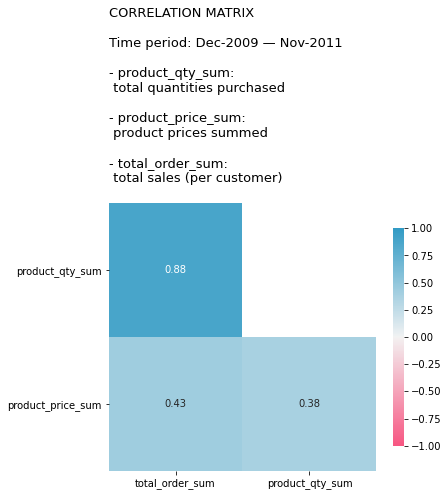

In [11]:
fig,ax= plt.subplots(figsize=(6,5))
# cmap="Blues"
cmap= sns.diverging_palette(0,230,90,60,as_cmap=True) 

sns.heatmap(cust_corr_masked,mask=mask,annot=True,fmt=".2f",cmap=cmap,vmin=-1,vmax=1,cbar_kws={"shrink":.8},square=True)

title= "CORRELATION MATRIX\n\nTime period: Dec-2009 — Nov-2011\n\n- product_qty_sum:\n total quantities purchased\n\n- product_price_sum:\n product prices summed\n\n- total_order_sum:\n total sales (per customer)\n"
plt.title(title,loc="left",fontsize=13)

plt.yticks(rotation=0)
plt.show()

### Scatter-plot

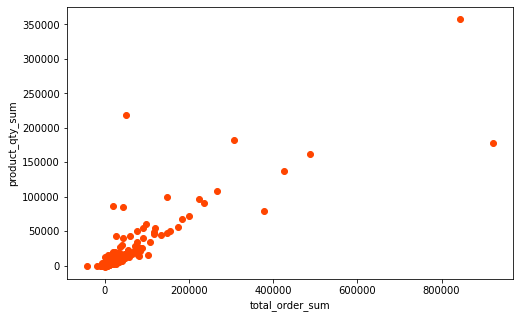

In [12]:
fig,ax= plt.subplots(1,figsize=(8,5))

sns.kdeplot(customer_grouped.total_order_sum,customer_grouped.product_qty_sum,cmap="Blues",shade=True,shade_lowest=False,clip=(-1,300))

plt.scatter(customer_grouped.total_order_sum,customer_grouped.product_qty_sum,color="orangered")

plt.show()

---
## Question 2

- 문자열에 대한 인코딩을 하여서 제출하시오.(코드 및 결과까지)


### `country` in key statistics 
- `country`: a geographic location at the time when a customer made an order.

In [14]:
data.country.describe()

count             780502
unique                41
top       United Kingdom
freq              700317
Name: country, dtype: object

In [15]:
data.country.value_counts()

United Kingdom          700317
Germany                  16999
EIRE                     15694
France                   13557
Netherlands               5051
Spain                     3683
Switzerland               3058
Belgium                   3012
Portugal                  2312
Australia                 1890
Channel Islands           1640
Italy                     1499
Sweden                    1341
Norway                    1235
Cyprus                    1153
Finland                   1035
Austria                    931
Denmark                    786
Greece                     627
Japan                      557
Poland                     527
Unspecified                521
USA                        492
United Arab Emirates       386
Singapore                  346
Israel                     321
Malta                      294
Canada                     228
Iceland                    211
Lithuania                  154
RSA                        123
Brazil                      94
Thailand

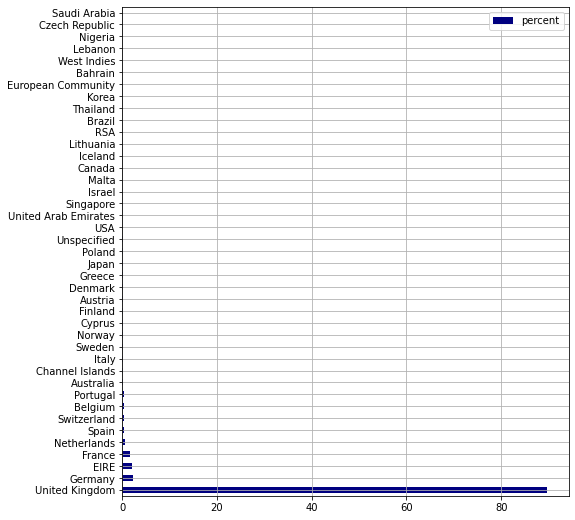

In [16]:
country_pct= (data.country.value_counts(sort=True)/data.shape[0])*100

fig,ax= plt.subplots(figsize=(8,9))
country_pct.plot(kind="barh", ax=ax,color="navy",label="percent")
plt.legend()
plt.grid()
plt.show()

### Encode `country` into numeric type

- sklearn.preprocessing.`LabelEncoder`
- sklearn.preprocessing.`OneHotEncoder`

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

enc_label= LabelEncoder()
enc_onehot = OneHotEncoder(handle_unknown="ignore")

df_country_encoded= data[["customer_id","country"]]

df_country_encoded["country_code"]= enc_label.fit_transform(df_country_encoded.country)

country_code_series= enc_onehot.fit_transform(df_country_encoded[["country_code"]]).toarray()

# country_code_series.shape # (780502, 41)

df_country_encoded= df_country_encoded.join(pd.DataFrame(country_code_series))

df_country_encoded.head(1)

,customer_id,country,country_code,0,1,2,3,4,5,6,...,31,32,33,34,35,36,37,38,39,40
0,13085,United Kingdom,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


---
## Question 3

- 모델을 선택하여 학습을 하고, 정확도,recall,precision을 출력하여서 제출하시오.

- Helper functions

    - `generate_label()`
    - `print_score()`

- Baseline model provided

    - `baseline_no_ml()`

In [23]:
TOTAL_TH= 300 # threshold

def generate_label(df,yr_mon,total_th=TOTAL_TH,print_log=False):

    df= df.copy()
    df["yr_mon"] = df["order_date"].str.slice(stop=7)

    cust= df[df["yr_mon"]<yr_mon]["customer_id"].unique()
    df= df[df["yr_mon"]==yr_mon]

    df_lbl= pd.DataFrame({"customer_id":cust})
    df_lbl["yr_mon"]= yr_mon

    total_sum= df.groupby(["customer_id","yr_mon"],as_index=False)["total"].sum()

    df_lbl= df_lbl.merge(total_sum,on=["customer_id","yr_mon"],how="left")
    df_lbl["total"].fillna(0.0,inplace=True)
    df_lbl["label"]= (df_lbl["total"]>total_th).astype(int)

    df_lbl= df_lbl.sort_values("customer_id").reset_index(drop=True)
    if print_log: print(f"{yr_mon}: final label shape: {df_lbl.shape}")

    return df_lbl

In [20]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score

def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

### Baseline model (provided)

- The baseline model forecasts the targeted month (December) sales based on the sales of the previous month (November)

In [20]:
import datetime
import dateutil.relativedelta

def baseline_no_ml(df,yr_mon,total_th=TOTAL_TH):

    df_mon= generate_label(df,yr_mon) #returns df_lbl
    
    d= datetime.datetime.strptime(yr_mon,"%Y-%m")
    prev_d= d - dateutil.relativedelta.relativedelta(months=1)
    prev_d= prev_d.strftime("%Y-%m")

    df_mon_prev= generate_label(df,prev_d) #returns df_lbl
    df_mon_prev= df_mon_prev.rename(columns={"total":"prev_total"})

    df_mon= df_mon.merge(df_mon_prev[["customer_id","prev_total"]],on="customer_id",how="left")

    df_mon["prev_total"]= df_mon["prev_total"].fillna(0)

    # compute prob. of 300+ total next month
    df_mon["probability"]= df_mon["prev_total"]/total_th
    df_mon.loc[df_mon["probability"]>1,"probability"]= 1
    df_mon.loc[df_mon["probability"]<0,"probability"]= 0

    return df_mon[["customer_id","probability"]]

In [5]:
data_dec= label.drop("year_month",axis=1)
data_dec["order_date"]= "2011-12"

data= train.append(data_dec,sort=False)
data.fillna(0,inplace=True)

data.shape

(786416, 10)

### The actual December label in bar-plot

0    5914
Name: label, dtype: int64

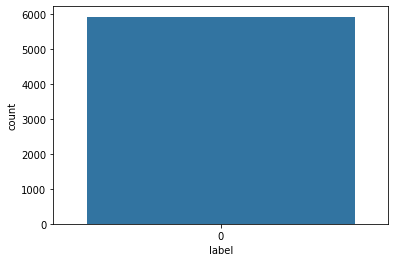

In [25]:
label_2011_dec= generate_label(data,"2011-12")["label"]

sns.countplot(label_2011_dec)
label_2011_dec.value_counts()

### December sales forecast

In [23]:
label_2011_dec= generate_label(data,"2011-12")["label"]

pred_2011_dec= baseline_no_ml(data,"2011-12")
pred_2011_dec.shape

(5914, 2)

### Evaluation metrics

In [24]:
print_score(label_2011_dec, pred_2011_dec["probability"])

Precision: 0.19759
Recall: 0.62000
F1 Score: 0.29968
ROC AUC Score: 0.71471


---
## Question 4

- Feature engineering을 이용하여서 학습을 진행한 후 좀 더 좋아졌다면 왜 좋아졌는지 혹은 안 좋아졌다면 왜 안좋아졌는지를 서술하시오.

### Feature Engineering

- `total` time-series: the monthly total (order amount) during the 24-month period

- helper function: `get_cust_df_list()`

In [4]:
def get_cust_df_list(custid_arr,cust_mon_total_df):
    
    cust_df_list= []
    period_index= pd.date_range("2009-12", periods=24, freq="MS")

    for cust_id in custid_arr:
        totals= np.zeros(24)
        cust_df= cust_mon_total_df.loc[cust_mon_total_df.customer_id==cust_id,["yr_mon_code","mon_total_sum"]]

        for i,series in cust_df.iterrows():
            # series: [0., 187.275] month 0, total 187.275
            totals[int(series[0])]= series[1]
            totals_df= pd.DataFrame(totals,index=period_index,columns=["total"])
            cust_df_list.append((cust_id, totals_df))

    return cust_df_list

### Create the `total` time series for each customer

- `cust_id_arr`: array of customer_id

- `cust_mon_total_df`: dataframe containing monthly total amounts

In [5]:
data= train.copy()

data["yr_mon"]= data.order_date.str.slice(stop=7)

cust_mon_total_df= data.groupby(["customer_id","yr_mon"])["total"].sum().rename("mon_total_sum").to_frame().reset_index()

cust_mon_total_df.head(1)

,customer_id,yr_mon,mon_total_sum
0,12346,2009-12,187.275


In [7]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
cust_mon_total_df["yr_mon_code"]= le.fit_transform(cust_mon_total_df.yr_mon)

cust_mon_total_df.head(2)

,customer_id,yr_mon,mon_total_sum,yr_mon_code
0,12346,2009-12,187.275,0
1,12346,2010-01,-22.275,1


In [8]:
cust_id_arr=data.customer_id.unique()

print(cust_id_arr.shape)

cust_id_arr[:3]

(5914,)


array([13085, 13078, 15362], dtype=int64)

In [9]:
import time

start_time= time.time()

# get the time series
cust_df_list= get_cust_df_list(cust_id_arr,cust_mon_total_df)

elapsed_time= time.time() - start_time

print(f"Elapsed time to create the time series: "
f"{elapsed_time:.3f} seconds")

Elapsed time to create the time series: 13.115 seconds


### Prediction Model: Autoregressive Integrated Moving Average (ARIMA)

- Code based on: _How to Create an ARIMA Model for Time Series Forecasting in Python_

    - https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/

- Helper function: `get_total_pred()`

In [10]:
warnings.filterwarnings('ignore','statsmodels.tsa.arima_model.ARMA',FutureWarning)

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.tseries.offsets import DateOffset

def get_total_pred_v1(cust_df_list):

    pred_dict= {}
    for tup in cust_df_list:
        # tup: (customer_id,total_df)
        # for non-stationary data: p,d,q=(1,1,0)
        total_df= tup[1]

        try:
            model= ARIMA(total_df["total"],order=(1,0,0))
            model_fit= model.fit()
        except:
            pass
        # model_fit.summary()

        next_mons= [total_df.index[-1]+DateOffset(months=x) for x in range(0,2)] # next one month

        next_mon_df= pd.DataFrame(index=next_mons[1:],columns=total_df.columns)

        forecast_df= pd.concat([total_df,next_mon_df])

        # forecast_df["total_pred"]= model_fit.predict(start=24,end=25,dynamic=True) # predict dec, jan
        
        total_pred= model_fit.predict(start=24,end=24,dynamic=True)
        forecast_df["total_pred"]= total_pred # predict dec
    # tup[0]: customer_id
    # pred_dict[tup[0]]= forecast_df.total_pred #return next month prediction
        pred_dict[tup[0]]= total_pred #return next month prediction

    return pred_dict

In [42]:
from statsmodels.tsa.arima_model import ARIMA

def get_total_pred(cust_df_list):
    pred_dict= {}
    for tup in cust_df_list:
        # tup: (customer_id,total_df)        
        total_df= tup[1]

        try: 
            # for non-stationary data: p,d,q=(1,1,0)
            model= ARIMA(total_df["total"],order=(1,1,0))
            model_fit= model.fit()
        except:
            pass
        
        total_pred= model_fit.predict(start=24,end=24,dynamic=True) # 24: next month index
        
        pred_dict[tup[0]]= total_pred

    return pred_dict       

In [ ]:
start_time= time.time()
total_preds= get_total_pred_v1(cust_df_list)
elapsed_time_v1= time.time() - start_time

In [13]:
print(f"Elapsed time to predict the next month `total`: "
f"{elapsed_time_v1:.3f} seconds")

Elapsed time to predict the next month `total`: 2043.477 seconds


In [ ]:
start_time= time.time()
total_preds= get_total_pred(cust_df_list)
elapsed_time= time.time() - start_time

In [ ]:
print(f"Elapsed time to predict the next month `total`: "
f"{elapsed_time:.3f} seconds")

### Post-Processing

In [14]:
pred_list= []
for i,val in enumerate(total_preds.values()):
    pred_list.append(val.values[0])
pred_list[:5]

[78.60872780523363,
 2133.1172874785234,
 44.28792092158022,
 36771.82019170901,
 565.1896639172062]

In [15]:
pred_df= pd.DataFrame(data=list(zip(total_preds.keys(),pred_list)),columns=["customer_id","total"])

pred_df.head()

,customer_id,total
0,13085,78.608728
1,13078,2133.117287
2,15362,44.287921
3,18102,36771.820192
4,12682,565.189664


#### Model training error

- Model-fitting on 18 time series (for 18 customers) failed

- Prediction values are imputed with zero.

In [16]:
pred_df.total.duplicated().value_counts()

False    5898
True       16
Name: total, dtype: int64

In [17]:
pred_df_copy= pred_df.copy()
pred_df_copy.loc[pred_df.total.duplicated(),"total"]= 0

In [18]:
threshold= 300

pred_df_copy["probability"]= pred_df_copy.total/threshold

pred_df_copy.loc[pred_df_copy.probability>1,"probability"]= 1
pred_df_copy.loc[pred_df_copy.probability<0,"probability"]= 0

pred_df_copy.head()

,customer_id,total,probability
0,13085,78.608728,0.262029
1,13078,2133.117287,1.000000
2,15362,44.287921,0.147626
3,18102,36771.820192,1.000000
4,12682,565.189664,1.000000


### Submission

In [8]:
file_label_arima= "submission_arima.csv"

label_arima= pd.read_csv(filepath+file_label_arima)

### Evaluation Metrics

In [ ]:
pred_2011_dec= pred_df_copy.drop("total",axis=1)

print_score(label_2011_dec, pred_2011_dec["probability"])

In [9]:
# pred_2011_dec= pred_df_copy.drop("total",axis=1)

print_score(label_2011_dec, label_arima["probability"])

Precision: 0.20710
Recall: 0.68667
F1 Score: 0.31823
ROC AUC Score: 0.77312


### Conclusion

- Prediction based on the 24-month time series of monthly `total` outperforms the baseline model

![baseline vs arima](./baseline_vs_arima_scores.png "baseline model scores vs ARIMA scores")

---
## Question 5

- 피쳐 중요도 플롯을 제출하시오.

### Feature Importance with Forest of Trees

- Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
data= train.copy()

order_df= data.groupby("customer_id")["order_date"].max().str.slice(stop=7).rename("order_mon_last").to_frame().reset_index()

In [9]:
data["yr_mon"]= data.order_date.str.slice(stop=7)

order_mon_cnt= data.groupby("customer_id")["yr_mon"].nunique().rename("order_mon_cnt")

order_df.insert(loc=1,column=order_mon_cnt.name,value=order_mon_cnt.values)

order_df.head(1)

,customer_id,order_mon_cnt,order_mon_last
0,12346,6,2011-01


In [10]:
num_uniq_products= data.groupby("customer_id")["product_id"].nunique().rename("num_uniq_products")

order_df.insert(loc=order_df.columns.shape[0],column=num_uniq_products.name,value=num_uniq_products.values)

order_df.head(1)

,customer_id,order_mon_cnt,order_mon_last,num_uniq_products
0,12346,6,2011-01,30


In [11]:
qty_total= data.groupby("customer_id")["quantity"].sum().rename("qty_total")

order_df.insert(loc=order_df.columns.shape[0],column=qty_total.name,value=qty_total.values)

order_df.head(1)

,customer_id,order_mon_cnt,order_mon_last,num_uniq_products,qty_total
0,12346,6,2011-01,30,53


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

enc_lbl_mon= LabelEncoder()
enc_1hot_mon= OneHotEncoder(handle_unknown="ignore")

mon_df= pd.DataFrame(enc_lbl_mon.fit_transform(order_df.order_mon_last),columns=["order_mon_last"])

mon_1hot_df= pd.DataFrame(enc_1hot_mon.fit_transform(mon_df[["order_mon_last"]]).toarray())

order_details_df= order_df.join(mon_1hot_df).drop("order_mon_last",axis=1)

order_details_df.head(1)

,customer_id,order_mon_cnt,num_uniq_products,qty_total,0,1,2,3,4,5,...,14,15,16,17,18,19,20,21,22,23
0,12346,6,30,53,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
total_df= data.groupby(["customer_id"])["total"].sum().rename("total_sum").to_frame().reset_index()

total_df.head(1)

,customer_id,total_sum
0,12346,-85.371


In [14]:
total_df= data.groupby(["customer_id"])["total"].sum().rename("total_sum").to_frame().reset_index()
total_df["total_mean"]= round(total_df.total_sum/order_details_df.order_mon_cnt,2)

total_df.head(1)

,customer_id,total_sum,total_mean
0,12346,-85.371,-14.23


#### Merge two dataframes with new features into one

In [15]:
total_df= data.groupby(["customer_id"])["total"].sum().rename("total_sum").to_frame().reset_index()
total_df["total_mean"]= round(total_df.total_sum/order_details_df.order_mon_cnt,2)

data_new_features= total_df.merge(order_details_df,on="customer_id",how="outer")

data_new_features.head(1)

,customer_id,total_sum,total_mean,order_mon_cnt,num_uniq_products,qty_total,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
0,12346,-85.371,-14.23,6,30,53,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Determine the new features' importance

In [16]:
X,y= data_new_features.drop("customer_id",axis=1), label["label"]

X_train,X_test,y_train,y_test= train_test_split(X,y,stratify=y,random_state=42)

#### Random Forest classifier for computing feature importance

In [17]:
from sklearn.ensemble import RandomForestClassifier

feature_names= [f"feature {X.columns[i]}" for i in range(X.shape[1])]

forest= RandomForestClassifier(random_state=0)
forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [18]:
import time

start_time= time.time()
importances= forest.feature_importances_
std= np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
elapsed_time= time.time() - start_time

print(f"Elapsed time to compute the importances: "
f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.018 seconds


#### Visualize the impurity-based importance

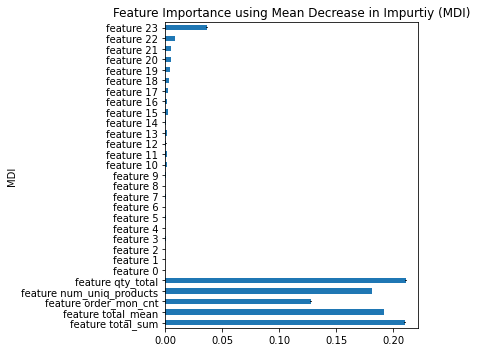

In [21]:
forest_importances= pd.Series(importances,index=feature_names)

fig,ax= plt.subplots(figsize=(6,5))
forest_importances.plot.barh(yerr=std,ax=ax)

ax.set_title("Feature Importance using Mean Decrease in Impurtiy (MDI)")
ax.set_ylabel("MDI")

fig.tight_layout()